<a href="https://colab.research.google.com/github/chen-szuyu-cody/Class_Practices/blob/master/Chapter_08_Naive_Bayes_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8: The Naive Bayes Classifier

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [2]:
!pip install dmba

In [3]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt
from dmba import classificationSummary, gainsChart


no display found. Using non-interactive Agg backend


In [0]:
from google.colab import files
import io
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['UniversalBank.csv']))

# delays_df = pd.read_csv('FlightDelays.csv')
# delays_df.head()

In [12]:
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [22]:
pd.pivot_table(df[['Online', 'CreditCard', 'Personal Loan']],index=['Online'], values=['CreditCard', 'Personal Loan'], aggfunc='sum')

,CreditCard,Personal Loan
Online,,
0,588,189
1,882,291


In [49]:
print(df[(df['Online']==0) & (df['CreditCard']==1)]['CreditCard'].value_counts())
print(df[(df['Online']==1) & (df['CreditCard']==1)]['CreditCard'].value_counts())
print(df[(df['Online']==0) & (df['Personal Loan']==1)]['Personal Loan'].value_counts())
print(df[(df['Online']==1) & (df['Personal Loan']==1)]['Personal Loan'].value_counts())

1    588
Name: CreditCard, dtype: int64
1    882
Name: CreditCard, dtype: int64
1    189
Name: Personal Loan, dtype: int64
1    291
Name: Personal Loan, dtype: int64


In [98]:
print(len(df[df['Online']==1]))
print(len(df[df['CreditCard']==1]))

2984
1470


In [104]:
'''8.1(a)
'''
pd.set_option('display.max_rows', 100)
import numpy as np

# print(pd.melt(df, id_vars=["Online"], value_vars=['CreditCard', 'Personal Loan']))

df_melt = pd.melt(df[['Online', 'CreditCard', 'Personal Loan']], id_vars=['Online'], var_name="Attribute", value_name="Value").sort_values(by='Online')
print(pd.pivot_table(df_melt, index=['Attribute'], columns=['Online'], values=['Value'], aggfunc=sum))


              Value     
Online            0    1
Attribute               
CreditCard      588  882
Personal Loan   189  291


In [108]:
df_melt = pd.melt(df[['Personal Loan', 'CreditCard', 'Online']], id_vars=['Personal Loan'], var_name="Attribute", value_name="Value").sort_values(by='Personal Loan')
print(pd.pivot_table(df_melt, index=['Attribute'], columns=['Personal Loan'], values=['Value'], aggfunc=sum))

              Value     
Personal Loan     0    1
Attribute               
CreditCard     1327  143
Online         2693  291


In [109]:
'''8.1(b)
'''
(143/ (143+291 )) * (291/ (143+291 )) * (143+291)/(1327+2693+143+291)

0.02152727626386679

In [111]:
'''8.1(c)
'''
predictors = ['CreditCard', 'Online']
for predictor in predictors:
    # construct the frequency table
    freqTable = df[['Personal Loan', predictor]].pivot_table(index='Personal Loan', columns=predictor, aggfunc=len)
    print(freqTable)
    print()

CreditCard        0     1
Personal Loan            
0              3193  1327
1               337   143

Online            0     1
Personal Loan            
0              1827  2693
1               189   291



In [112]:
'''8.1(d)
'''
predictors = ['CreditCard', 'Online']
for predictor in predictors:
    # construct the frequency table
    freqTable = df[['Personal Loan', predictor]].pivot_table(index='Personal Loan', columns=predictor, aggfunc=len)
    # print(freqTable)
    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()

CreditCard            0         1
Personal Loan                    
0              0.706416  0.293584
1              0.702083  0.297917

Online                0         1
Personal Loan                    
0              0.404204  0.595796
1              0.393750  0.606250



In [113]:
print(len(df[df['Personal Loan']==1])/len(df))

0.096


In [114]:
print(len(df[df['Personal Loan']==0])/len(df))

0.904


In [115]:
'''8.1(e)
'''
# P(CC=1|L=1)*P*(OL=1|L=1)*P(L=1)
0.297917*0.606250*0.096

0.0173387694

In [0]:
'''8.1(f)
'''
# 0.02152727626386679 vs. 0.0173387694

In [0]:
'''8.1(g)
'''
predictors = ['CreditCard', 'Online']
outcome = 'Personal Loan'

X = pd.get_dummies(df[predictors])
y = (df[outcome] == 1).astype(int)
classes = [1, 0]

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)

In [118]:
# split the original data frame into a train and test using the same random_state
train_df, valid_df = train_test_split(df, test_size=0.4, random_state=1)

pd.set_option('precision', 4)
# probability of flight status
print(df['Personal Loan'].value_counts() / len(train_df))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_df[['Personal Loan', predictor]]
    freqTable = df.pivot_table(index='Personal Loan', columns=predictor, aggfunc=len)

    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('precision')

0    1.5067
1    0.1600
Name: Personal Loan, dtype: float64

CreditCard          0       1
Personal Loan                
0              0.7036  0.2964
1              0.6934  0.3066

Online              0       1
Personal Loan                
0              0.4125  0.5875
1              0.3902  0.6098



In [0]:
# # P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
# P_hat_delayed = 0.0958 * 0.1609 * 0.0307 * 0.4215 * 0.5211 * 0.1977
# # P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
# P_hat_ontime = 0.2040 * 0.1048 * 0.0519 * 0.5779 * 0.6478 * 0.8023
# print('P_hat_delayed ~ ', P_hat_delayed)
# print('P_hat_ontime ~ ', P_hat_ontime)

# print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
# print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

In [122]:
# Subset a specific set
df = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index=y_valid.index)], axis=1)
mask = ((X_valid.CreditCard == 1) & (X_valid.Online == 1))

print(df[mask])

      actual  predicted         0         1
932        0          0  0.904419  0.095581
1132       0          0  0.904419  0.095581
3289       0          0  0.904419  0.095581
348        1          0  0.904419  0.095581
2971       0          0  0.904419  0.095581
...      ...        ...       ...       ...
4705       1          0  0.904419  0.095581
2429       0          0  0.904419  0.095581
2684       0          0  0.904419  0.095581
3401       0          0  0.904419  0.095581
1239       0          0  0.904419  0.095581

[356 rows x 4 columns]


In [123]:
classificationSummary(y_train, y_train_pred, class_names=classes) 

print()

classificationSummary(y_valid, y_valid_pred, class_names=classes) 

Confusion Matrix (Accuracy 0.9043)

       Prediction
Actual    1    0
     1 2713    0
     0  287    0

Confusion Matrix (Accuracy 0.9035)

       Prediction
Actual    1    0
     1 1807    0
     0  193    0


In [131]:
df

,actual,prob
0,1,0.904506
1,1,0.904506
2,1,0.904506
3,1,0.904506
4,0,0.904506
...,...,...
1995,1,0.904246
1996,0,0.904246
1997,1,0.904246
1998,1,0.904246


In [144]:
df = pd.DataFrame({'actual': 1 - y_valid, 'prob': predProb_valid[:, 0]})
df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

,actual,prob
0,1,0.904506
1,1,0.904506
2,1,0.904506
3,1,0.904506
4,0,0.904506
...,...,...
1995,1,0.904246
1996,0,0.904246
1997,1,0.904246
1998,1,0.904246


In [0]:
import sys
import matplotlib

# print (plt.get_backend())
# import matplotlib.pyplot as plt
# matplotlib.rcParams['backend'] = 'TkAgg' 

df = pd.DataFrame({'actual': 1 - y_valid, 'prob': predProb_valid[:, 0]})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
gainsChart(df.actual, ax=ax)

plt.tight_layout()
plt.show()

## Table 8.4

In [0]:
delays_df = pd.read_csv('FlightDelays.csv')
delays_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [13]:
delays_df = pd.read_csv('FlightDelays.csv')

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors])
y = (delays_df[outcome] == 'delayed').astype(int)
classes = ['ontime', 'delayed']

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)

FileNotFoundError: ignored

In [0]:
delays_df = pd.read_csv('FlightDelays.csv')

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')
delays_df['Flight Status'] = delays_df['Flight Status'].astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors])
y = delays_df['Flight Status']
classes = list(y.cat.categories)

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)

## Table 8.5
First construct a frequency table and then convert it to the propability table

In [0]:
# split the original data frame into a train and test using the same random_state
train_df, valid_df = train_test_split(delays_df, test_size=0.4, random_state=1)

pd.set_option('precision', 4)
# probability of flight status
print(train_df['Flight Status'].value_counts() / len(train_df))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_df[['Flight Status', predictor]]
    freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)

    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('precision')

ontime     0.8023
delayed    0.1977
Name: Flight Status, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME       6       7       8       9       10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

ORIG

In [0]:
# P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_delayed = 0.0958 * 0.1609 * 0.0307 * 0.4215 * 0.5211 * 0.1977
# P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_ontime = 0.2040 * 0.1048 * 0.0519 * 0.5779 * 0.6478 * 0.8023
print('P_hat_delayed ~ ', P_hat_delayed)
print('P_hat_ontime ~ ', P_hat_ontime)

print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

P_hat_delayed ~  2.0548742506526157e-05
P_hat_ontime ~  0.00033326464123921066
P(delayed|...) =  0.05807791183301656
P(ontime|...) =  0.9419220881669834


## Table 8.6

In [0]:
# Subset a specific set
df = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index=y_valid.index)], axis=1)
mask = ((X_valid.CARRIER_DL == 1) & (X_valid.DAY_WEEK_7 == 1) & (X_valid.CRS_DEP_TIME_10 == 1) & 
        (X_valid.DEST_LGA == 1) & (X_valid.ORIGIN_DCA == 1))

print(df[mask])

      actual predicted         0         1
1225  ontime    ontime  0.057989  0.942011


## Table 8.7

In [0]:
classificationSummary(y_train, y_train_pred, class_names=classes) 

print()

classificationSummary(y_valid, y_valid_pred, class_names=classes) 

Confusion Matrix (Accuracy 0.7955)

        Prediction
 Actual delayed  ontime
delayed      52     209
 ontime      61     998

Confusion Matrix (Accuracy 0.7821)

        Prediction
 Actual delayed  ontime
delayed      26     141
 ontime      51     663


## Figure 8.1

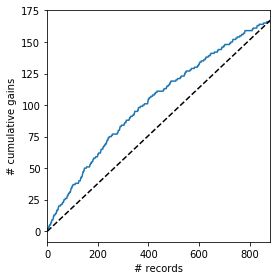

In [0]:
df = pd.DataFrame({'actual': 1 - y_valid.cat.codes, 'prob': predProb_valid[:, 0]})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
gainsChart(df.actual, ax=ax)

plt.tight_layout()
plt.show()

In [0]:
import numpy as np
np.exp(delays_nb.feature_log_prob_)

array([[0.03831098, 0.02988425, 0.02298965, 0.02528785, 0.03754491,
        0.01379685, 0.03218245, 0.00690226, 0.01073259, 0.01303079,
        0.00383799, 0.00613619, 0.00230586, 0.00996652, 0.00920046,
        0.00766832, 0.04060918, 0.01456292, 0.03065031, 0.00383799,
        0.01992539, 0.00307193, 0.01762719, 0.01609505, 0.10419268,
        0.07967856, 0.07584823, 0.03984311, 0.08427496, 0.01149866,
        0.0628251 , 0.01915932, 0.04443951, 0.00153979, 0.04367344,
        0.00307193, 0.01379685],
       [0.02492933, 0.02832852, 0.02889505, 0.03588229, 0.033805  ,
        0.02719546, 0.0209636 , 0.01246561, 0.01265445, 0.01699787,
        0.01133254, 0.01038832, 0.00680028, 0.01322098, 0.01492058,
        0.01152139, 0.02341857, 0.01548711, 0.02001938, 0.00698912,
        0.00793335, 0.00528953, 0.01057716, 0.01208792, 0.12954902,
        0.05835475, 0.05325596, 0.03116118, 0.11557455, 0.00698912,
        0.04589103, 0.04079224, 0.02341857, 0.00207917, 0.033805  ,
        0.00340